In [4]:
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.ops import unary_union
import os, glob

In [5]:
os.getcwd()

'C:\\Users\\GEOMATICA\\Curso_Geomatica\\06_BGR_Geomatica\\Datos\\Script'

In [6]:
ruta_archivos = r"C:\Users\GEOMATICA\Curso_Geomatica\06_BGR_Geomatica\Datos\Shp"
os.chdir(ruta_archivos) # Cambiar ruta trabajo
os.getcwd() # Consultar ruta trabajo

'C:\\Users\\GEOMATICA\\Curso_Geomatica\\06_BGR_Geomatica\\Datos\\Shp'

In [7]:
lista = glob.glob("*.shp")
lista

['Grilla1.shp',
 'Grilla1_label.shp',
 'Grilla2.shp',
 'Grilla2_label.shp',
 'Zona_Parcela.shp']

In [8]:
# cargar un shp
shp_gdp = gpd.read_file(lista[4])
shp_gdp

,Id,geometry
0,0,"POLYGON ((522298.171 9028900.509, 520737.679 9..."


In [9]:
shp_gdp.crs.name

'WGS 84 / UTM zone 18S'

In [54]:
shp_gdp_500 = shp_gdp.buffer(500)

In [55]:
# Paso 3: Calcular el ancho y alto en metros
bbox = unary_union(shp_gdp_500.geometry).bounds
width_metros = 5000  # Ancho de cada polígono en metros
height_metros = 5000  # Alto de cada polígono en metros

In [56]:
from math import ceil

In [57]:
# Paso 4: Calcular el número de filas y columnas necesarias
xmin, ymin, xmax, ymax = bbox
num_columnas = ceil((xmax - xmin) / width_metros)
num_filas = ceil((ymax - ymin) / height_metros)

In [58]:
# Paso 5: Crear la malla de polígonos (fishnet)
poligonos = []
for i in range(num_columnas):
    for j in range(num_filas):
        x = xmin + i * width_metros
        y = ymin + j * height_metros
        poligono = Polygon([(x, y), (x + width_metros, y), (x + width_metros, y + height_metros), (x, y + height_metros)])
        poligonos.append(poligono)

In [59]:
# Paso 6: Crear un GeoDataFrame con los polígonos de la malla
malla = gpd.GeoDataFrame({'geometry': poligonos}, crs=shp_gdp.crs)

In [61]:
# Paso 3: Realizar una unión espacial entre la parcela y la malla
malla_seleccionada = gpd.sjoin(malla, shp_gdp, how='inner', predicate='intersects')

<Axes: >

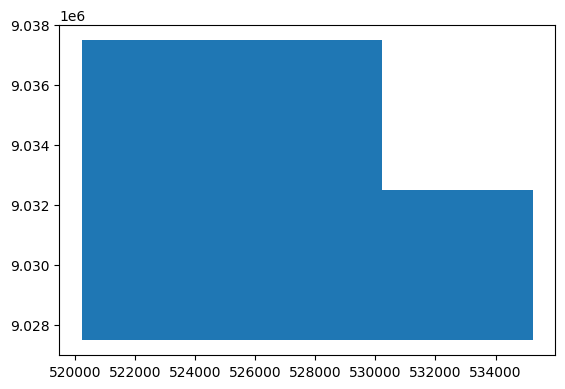

In [62]:
malla_seleccionada.plot()

In [63]:
type(malla_seleccionada)

geopandas.geodataframe.GeoDataFrame

In [64]:
malla_seleccionada.head(5)

,geometry,index_right,Id
0,"POLYGON ((520237.999 9027505.412, 525237.999 9...",0,0
1,"POLYGON ((520237.999 9032505.412, 525237.999 9...",0,0
2,"POLYGON ((525237.999 9027505.412, 530237.999 9...",0,0
3,"POLYGON ((525237.999 9032505.412, 530237.999 9...",0,0
4,"POLYGON ((530237.999 9027505.412, 535237.999 9...",0,0


In [65]:
malla_seleccionada.columns

Index(['geometry', 'index_right', 'Id'], dtype='object')

In [66]:
# Paso 2: Eliminar la columna
columna_a_eliminar = 'index_right'
malla_seleccionada = malla_seleccionada.drop(columns=[columna_a_eliminar])

In [67]:
# Paso 2: Generar nombres consecutivos para la nueva columna
Name = []
prefijo = 'Parcela_'
for i in range(1, len(malla_seleccionada) + 1):
    nombre = prefijo + str(i)
    Name.append(nombre)

# Paso 3: Agregar la nueva columna al GeoDataFrame
malla_seleccionada['Nombre'] = Name

In [68]:
malla_seleccionada.head(5)

,geometry,Id,Nombre
0,"POLYGON ((520237.999 9027505.412, 525237.999 9...",0,Parcela_1
1,"POLYGON ((520237.999 9032505.412, 525237.999 9...",0,Parcela_2
2,"POLYGON ((525237.999 9027505.412, 530237.999 9...",0,Parcela_3
3,"POLYGON ((525237.999 9032505.412, 530237.999 9...",0,Parcela_4
4,"POLYGON ((530237.999 9027505.412, 535237.999 9...",0,Parcela_5


In [69]:
# Paso 4: Guardar la malla seleccionada como un nuevo shapefile
malla_seleccionada.to_file('malla_seleccionada.shp')